# Does Oil Well Production Decrease with Age?

I explore the relationship between the age of an oil well and its output.  My preconceived notion is that a well is much more productive shortly after it begins prodcing than it is many months later.  This is because the resevoir that the well taps into depletes over time.

The data for this analysis comes from the Colorado Oil and Gas Conservation Commission. I'll look at wells completed after January 1, 1999 since that is the earliest date for which the COGCC provides downloadable production data.

## Observations

+ The number of well completions of approximately 1926 wells in 2017 represents the highest number of completions since 2012.
+ The boom years for well compeletions was the period 2005-2008 with 2008 topping 4000 completions. After the financial crash of 2008, completions dropped by over 50% in 2009 however quickly rebounded to the 3000 range by 2012.
+ The number of wells reporting production rose sharply throughout the boom years in completions, reaching a peak of 34,612 wells reporting production in 2014.  Since then, the number of wells reporting production has declined to 32,240 in 2017.
+ Oil production has more than quadrupled since 2008 from 28.1 M Bbl to 128.6 M Bbl in 2017.
+ Barrels per day (productivity) does appear to decline by age; a well's most productive years are its first 5 years.
+ Most wells are producing fewer than 20 barrels per day after 10 years
+ Over 90% of 2017 crude oil production came from four formations: N-COM, NBRR, CODL and CARL. Of these N-COM and CARL exhibited the highest productivity in terms of average barrels per well-day.  However the median well age of the wells in these formations were lower than in other formations.  This confounds the determination of whether these formations are inherently more productive or is their high productivity an  artifact of their wells being younger.
 
## Preliminaries

### Requisite Libraries

In [52]:
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely
import zipfile
import datetime
import pypyodbc
import matplotlib.pyplot as plt

%matplotlib inline

### Plot Defaults

In [53]:
# set some plot defaults
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.color'] = 'r'
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16

## Data Load

Here we look at the average barrels per day over the life of a well -- or at least that portion of a wells life for which we have data.

Data comes from COGGC downloads page: production data for the years 1999 through 2017. Each reporting year is a separate zip file containing an Microsoft Access database. We downloaded these files, used the SQL Server import tool to import the data into year-specific tables capturing production and well completion data. We then created a view which concatenated (union all) the production data tables. Finally we aggregated group by API_num, Report_year to get the production totals for each well for each year.

In [54]:
# read up the historical production and well data:

# connect to the db running on the local server:
connection = pypyodbc.connect('Driver={SQL Server};'
                                'Server=DESKTOP-08KBBTA\SQLEXPRESS;'
                                'Database=OilAndGas;')
# get the data
prod_hist    = pd.read_sql('select * from FactProduction', connection)
WellData_Raw = pd.read_sql('select * from [Completions 2017]',    connection)
#ditch the connection
connection.close()

### Clean Up the Completion Data

COGCC provides data about each well in the `Completions` table.  Not sure why but this table often contains more than one record for each well, perhaps because the well's operator changes mid-year or perhaps the formation that the well is working on is reclassified or ...
Another problem in the Completeion data is that many of the wells don't have geo-coordinates.  Though not an issue for this analysis, I'll get rid of them (I think most of these are for old or defunct wells)

Some well records are missing completion dates.  If available, I'll substitute first_production as a proxy for completion date in these cases

In [55]:
WellData_Raw.head()

,name,operator_num,facility_num,facility_name,well_name,api_county_code,api_seq_num,sidetrack_num,api_num,formation_code,...,wbmeasdepth,wbtvd,gas_type,test_date,well_bore_status,status_date,first_prod_date,form_status_date,formation_status,complete_date
0,RYAN OIL CO ...,75500.0,1-T,U P T PRICE,U P T PRICE,001,05010,00,05-001-05010-00,UNK,...,0.0,0.0,None,None,AB,1999-01-01,NaT,1999-01-01,AB,1955-03-18
1,PETRO-CANADA RESOURCES (USA) INC ...,72085.0,1,"NOONEN, MICHAEL","NOONEN, MICHAEL",001,05029,00,05-001-05029-00,JSND,...,6664.0,6664.0,None,None,PA,2000-06-22,1951-09-30,2000-06-22,AB,1951-09-09
2,PETRO-CANADA RESOURCES (USA) INC ...,72085.0,1-B,UPRR-NOONEN,UPRR-NOONEN,001,05040,00,05-001-05040-00,JSND,...,6205.0,0.0,None,None,PA,1994-10-31,1961-07-06,1994-10-31,AB,1961-06-14
3,PETRO-CANADA RESOURCES (USA) INC ...,72085.0,3,UPRR NOONEN,UPRR NOONEN,001,05041,00,05-001-05041-00,JSND,...,6275.0,0.0,None,1960-12-20 00:00:00,PA,1971-02-05,1960-12-20,1971-02-05,AB,1960-08-31
4,HAWKS* JEFF ...,38590.0,1-18,FLADER,FLADER,001,05042,00,05-001-05042-00,JSND,...,6625.0,6625.0,None,1959-07-03 00:00:00,PA,1961-02-09,1959-07-03,1961-02-09,AB,1959-06-03


In [56]:
# get rid of the dup API nummber records by taking first in group
DimWell = WellData_Raw.groupby('api_num').first()

# ditch the wells for which there's no longitude or latitude:
DimWell.dropna(axis=0, how='any', subset=['long','lat'],inplace=True)

# fix up the completion date and first_prod date columns:
DimWell['complete_date'] = pd.to_datetime(DimWell['complete_date'])
DimWell['first_prod_date'] = pd.to_datetime(DimWell['first_prod_date'])

# Set the CompleteDate to complete_date if available otherwise first_prod_date
DimWell['CompleteDate'] = np.where(DimWell.complete_date.isnull(),DimWell.first_prod_date,DimWell.complete_date)
print('number of oil wells: %d, wells missing complete dates: %d' % (len(DimWell),DimWell.CompleteDate.isnull().sum()))

number of oil wells: 73810, wells missing complete dates: 1965


### Clean up the Production data

I did most of the cleansing of the production data while loading the COGCC-files into the SQL Server DB.  This cleanup includes:
+ Creating an API_num column to enable joining with the well data
+ Concatenating the production tables for the years 1999-2017 into one table
+ Consolidating multiple records for the same well (as identitified by API_num) and same year into one record by summing the oil_prod and prod_days field
+ Excluding records where the oil_prod field is null
+ Ignoring all of  the gas and water fields


The result of this is one record for each well for each year.

In [57]:
(len(prod_hist), prod_hist.oil_prod.isnull().sum(), prod_hist.prod_days.isnull().sum())

(453497, 0, 43)

In [58]:
#calculate the average output per day and ditch the records with null prod_days
prod_hist['BblPerDay'] = prod_hist.oil_prod/prod_hist.prod_days
prod_hist.dropna(axis=0, how='any',inplace=True)
(len(prod_hist), prod_hist.oil_prod.isnull().sum(), prod_hist.prod_days.isnull().sum())

(453402, 0, 0)

In [59]:
# function to calculate the number of months between two arrays of dates
def months_since(datesto, datesfrom):
    m = [(d2.year - d1.year) * 12 + (d2.month - d1.month) for d1,d2 in zip(datesfrom,datesto)]
    return np.array(m)

In [60]:
# Get the completion date in prep for computing well age as report date

# convert the reporting year to 12/31/<reporting_year>
prod_hist['report_date'] = [pd.Timestamp(d.report_year,12,31) for d in prod_hist.itertuples()]

#get the completion date
prod_hist = prod_hist.merge(DimWell[['CompleteDate', 'formation_code']], left_on='api_num', right_index=True)

#calculate the age (in months) as of the reporting date
prod_hist['AgeAsOfReport'] = months_since(prod_hist.report_date, prod_hist.CompleteDate)

# get rid of any rows with negative age (i.e., completion date > report_date)
prod_hist = prod_hist.query('AgeAsOfReport >= 0')

In [61]:
prod_hist.head()

,api_num,report_year,oil_prod,prod_days,BblPerDay,report_date,CompleteDate,formation_code,AgeAsOfReport
0,05-001-05044-00,1999,317,46.0,6.891304,1999-12-31,1959-08-30,JSND,484.0
1,05-001-05242-00,1999,325,61.0,5.327869,1999-12-31,1953-09-02,DSND,555.0
12568,05-001-05242-00,2000,672,122.0,5.508197,2000-12-31,1953-09-02,DSND,567.0
25554,05-001-05242-00,2001,818,345.0,2.371014,2001-12-31,1953-09-02,DSND,579.0
139383,05-001-05242-00,2008,158,103.0,1.533981,2008-12-31,1953-09-02,DSND,663.0


In [62]:
# total number of wells and number of wells without completion dates:
(len(prod_hist.api_num.unique()),len(prod_hist.loc[prod_hist.CompleteDate.isnull()].api_num.unique()))

(43214, 0)

In [63]:
prod_hist.dropna(how='any', axis=0, inplace=True)
(len(prod_hist.api_num.unique()),len(prod_hist.loc[prod_hist.CompleteDate.isnull()].api_num.unique()))

(43214, 0)

In [64]:
prod_hist.tail()

,api_num,report_year,oil_prod,prod_days,BblPerDay,report_date,CompleteDate,formation_code,AgeAsOfReport
453469,05-123-45049-00,2017,17341,61.0,284.278689,2017-12-31,2017-08-01,N-COM,4.0
453470,05-123-45050-00,2017,13908,61.0,228.000000,2017-12-31,2017-09-01,N-COM,3.0
453471,05-123-45052-00,2017,17123,61.0,280.704918,2017-12-31,2017-08-01,N-COM,4.0
453472,05-123-45086-00,2017,137,5.0,27.400000,2017-12-31,2017-09-01,N-COM,3.0
453473,05-123-45416-00,2017,3565,31.0,115.000000,2017-12-31,2017-10-01,N-COM,2.0


## Annual Statistics

In [65]:
DimWell['CompleteYear']=[d.year for d in DimWell.CompleteDate]
WellsPost1999 = DimWell.query('CompleteDate >= \'1/1/1999\'')
len(DimWell),len(WellsPost1999)

(73810, 40326)

In [66]:
# function for data labels on barchart
def add_labels(ax, vals, format= "{val:,}", fontsize=16):
    rects = ax.patches

    # Make some labels.
    labels = [format.format(val=val)  for val in vals]

    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
                ha='center', va='bottom', fontsize=16)

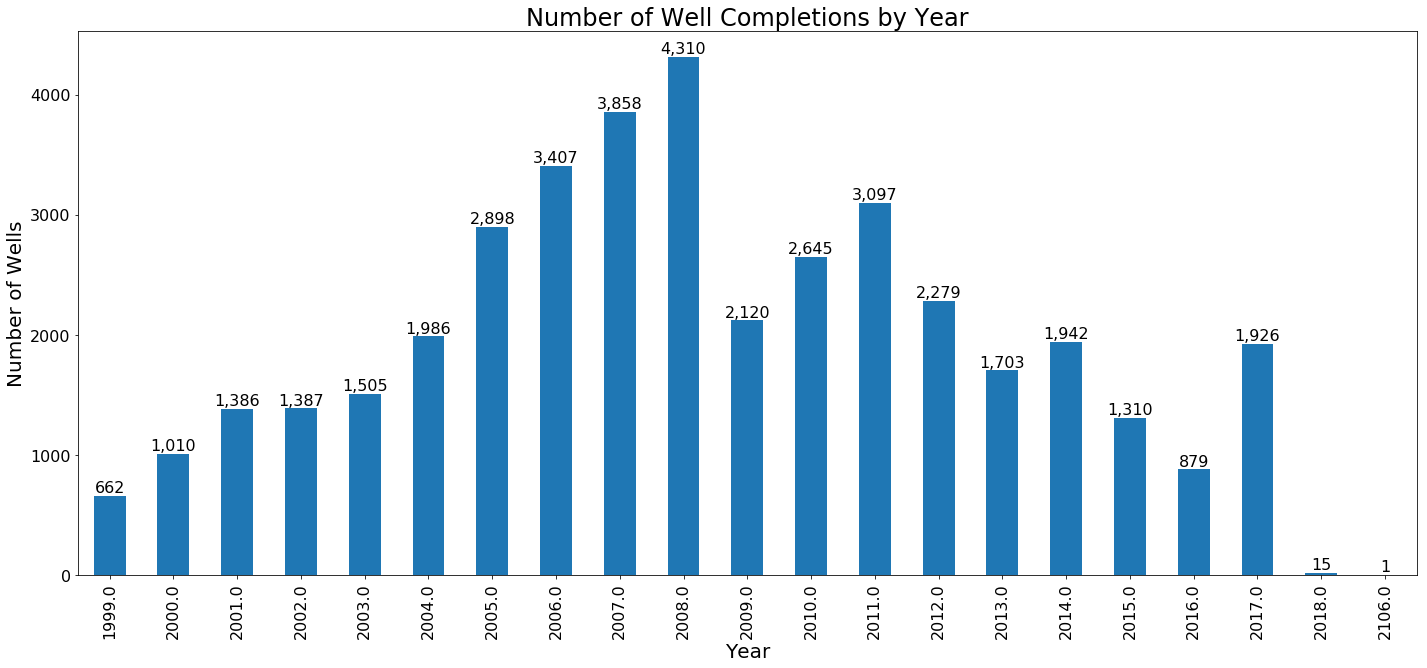

In [67]:

f = plt.figure(figsize=(24,10))
W99Count = WellsPost1999.groupby('CompleteYear').size()

ax = W99Count.plot.bar()

plt.title('Number of Well Completions by Year')
plt.ylabel('Number of Wells')
plt.xlabel('Year')
add_labels(ax,W99Count)

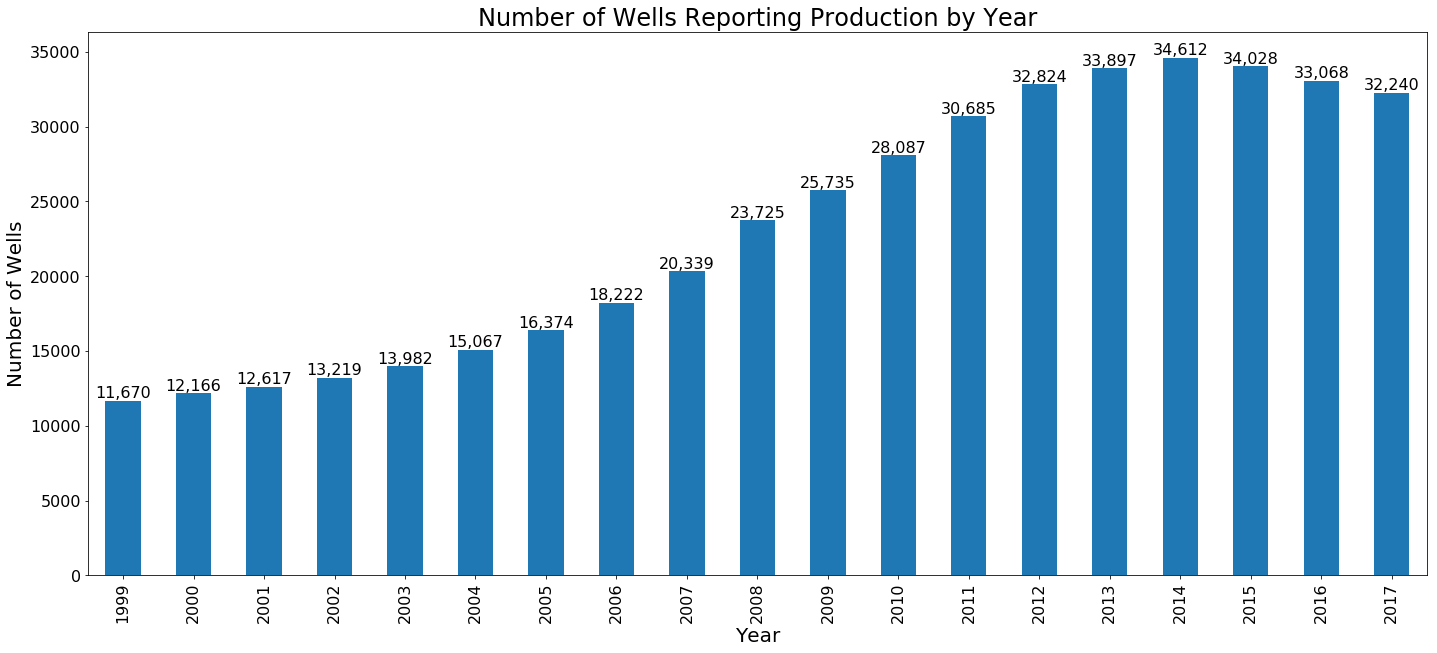

In [68]:

f = plt.figure(figsize=(24,10))
Nwells = prod_hist.groupby('report_year').size()

ax = Nwells.plot.bar()

plt.title('Number of Wells Reporting Production by Year')
plt.ylabel('Number of Wells')
plt.xlabel('Year')

add_labels(ax, Nwells)

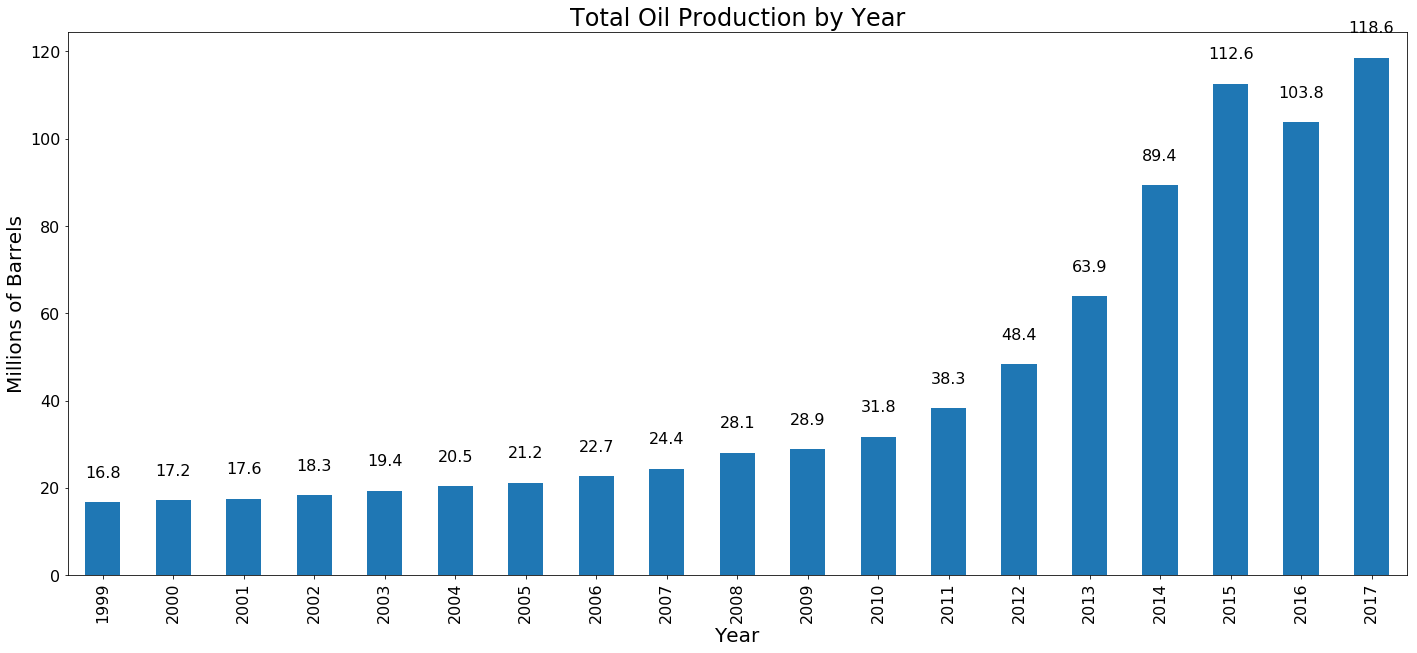

In [69]:
f = plt.figure(figsize=(24,10))
TotProd = (prod_hist.groupby('report_year')['oil_prod'].sum()/1000000)
ax = TotProd.plot.bar()

plt.title('Total Oil Production by Year')
plt.ylabel('Millions of Barrels')
plt.xlabel('Year')
add_labels(ax, TotProd, format='{val:4.1f}')

## Age Distribution of Wells

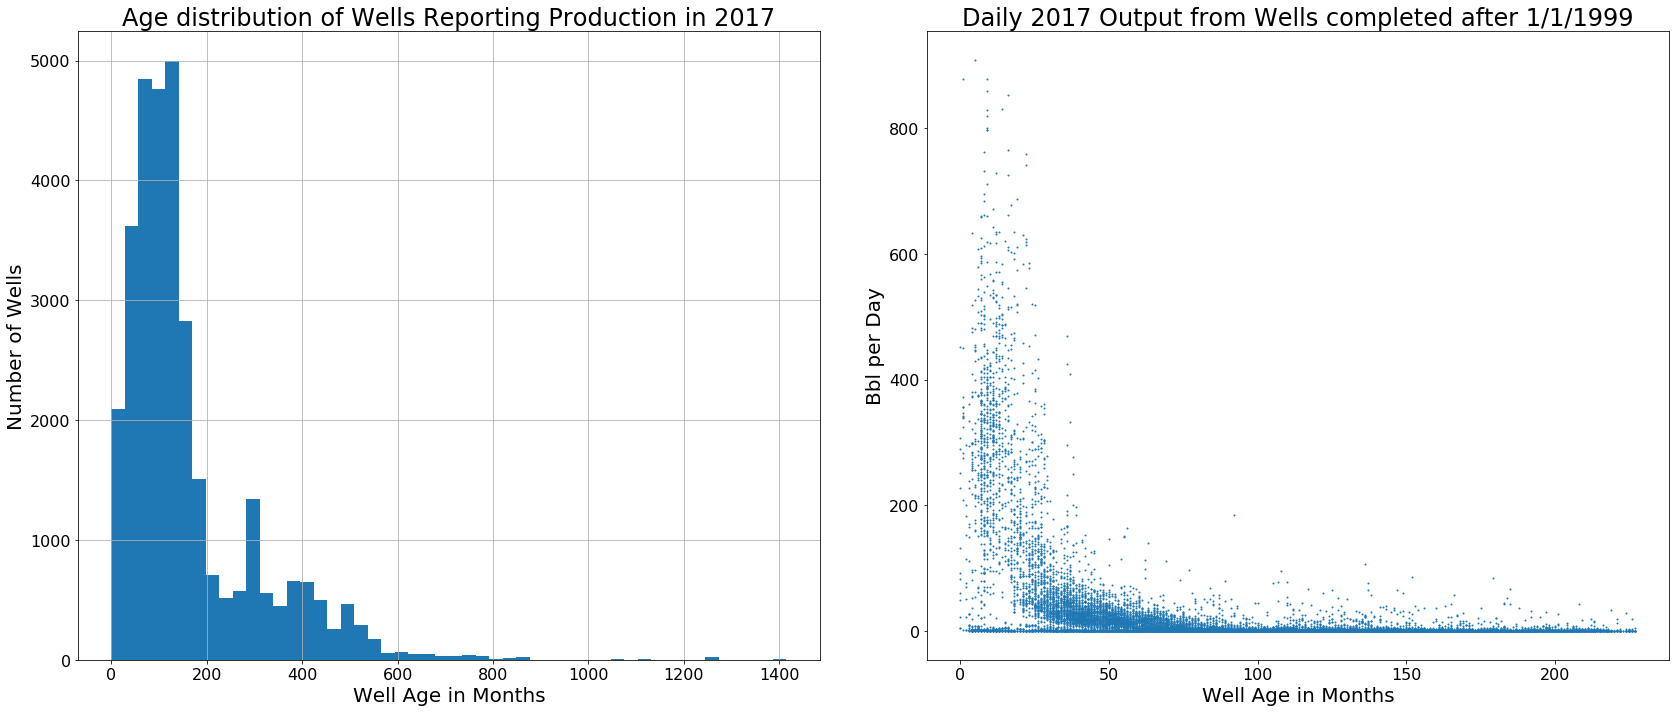

In [70]:
f = plt.figure(figsize=(24,10))
ax = plt.subplot(1,2,1)

prod_hist.query('report_year == 2017').hist('AgeAsOfReport',bins=50, ax=ax)
plt.title('Age distribution of Wells Reporting Production in 2017')
plt.ylabel('Number of Wells')
plt.xlabel('Well Age in Months')

oil_df = prod_hist.query('report_year == 2017 & CompleteDate >= \'1/1/1999\'')
ax = plt.subplot(1,2,2)
plt.scatter(oil_df.AgeAsOfReport, oil_df.BblPerDay, s=1)
plt.title('Daily 2017 Output from Wells completed after 1/1/1999')
plt.ylabel('Bbl per Day')
plt.xlabel('Well Age in Months')
plt.tight_layout()

### Median Output

In [71]:
# calculate median value for each age
prod_med = oil_df.groupby('AgeAsOfReport').median().BblPerDay
prod_med.head()

AgeAsOfReport
0.0     93.268437
1.0    342.004348
2.0     77.315789
3.0     27.200000
4.0      5.490591
Name: BblPerDay, dtype: float64

In [72]:
#first two points look anomalous, so zero them out!!
prod_med.iloc[0:2] = 0
prod_med.head()

AgeAsOfReport
0.0     0.000000
1.0     0.000000
2.0    77.315789
3.0    27.200000
4.0     5.490591
Name: BblPerDay, dtype: float64

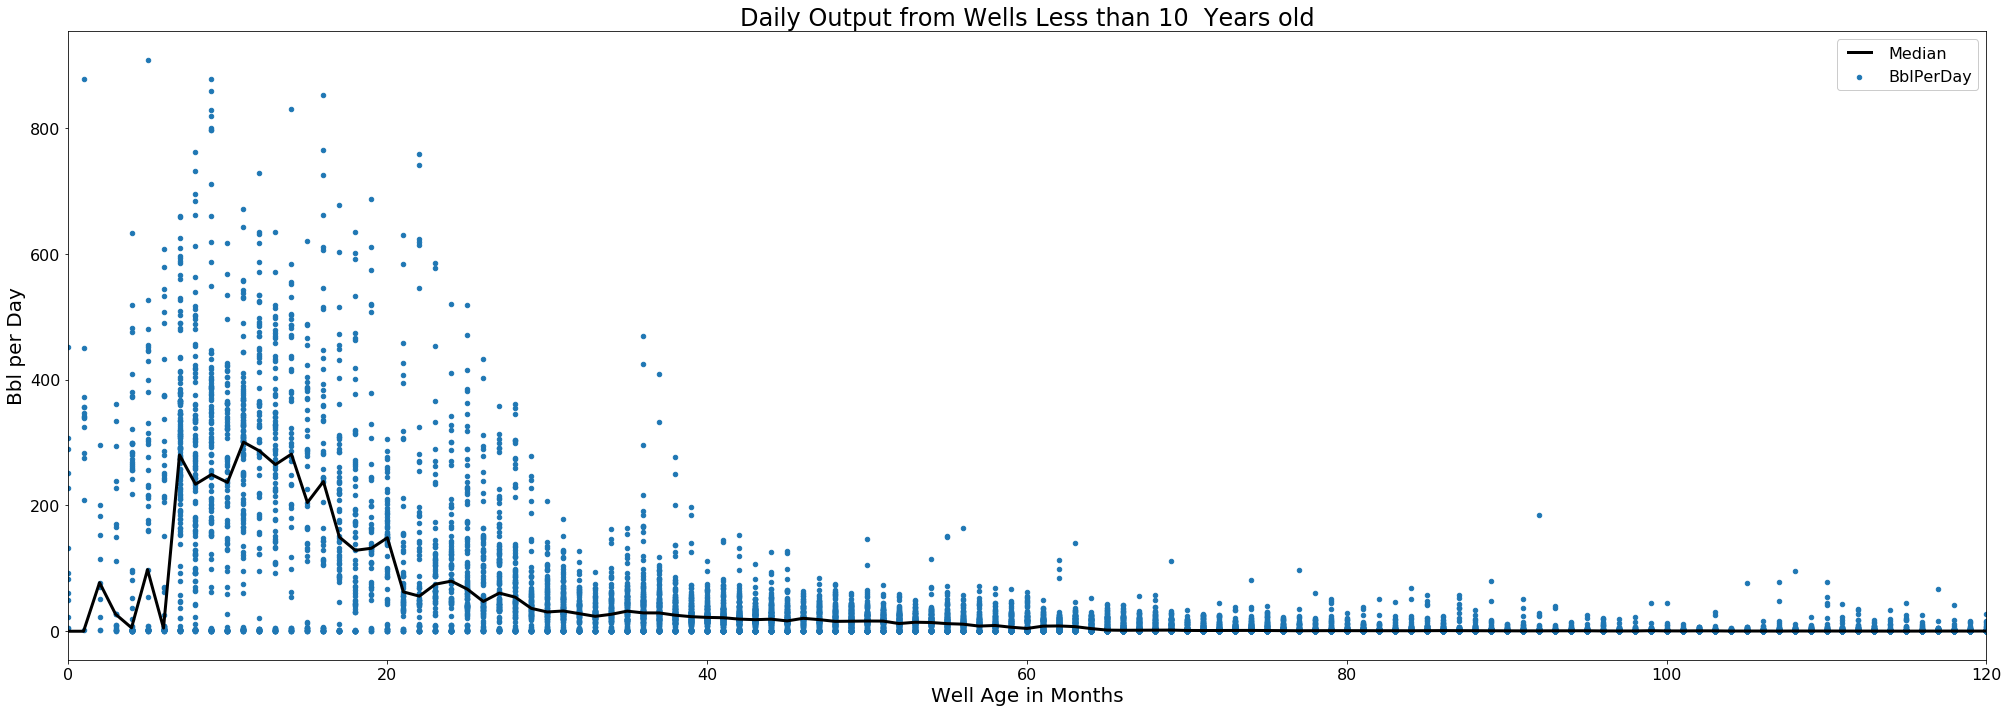

In [73]:
f = plt.figure(figsize=(28,10))
ax = plt.subplot()
ax.set_xlim(0,120)
plt.scatter(oil_df.AgeAsOfReport, oil_df.BblPerDay, s=20)
plt.title('Daily Output from Wells Less than 10  Years old')
plt.ylabel('Bbl per Day')
plt.xlabel('Well Age in Months')
plt.plot(prod_med.index, prod_med.values,color='black',label='Median')
plt.legend(numpoints=2,fontsize=16,markerscale=1, facecolor="white",framealpha=1)
plt.tight_layout()

## Productivity by Formation_code

+ make the same plot above only color code wells by formation code
+ how many formations?
+ what's age distribution in each formation?

In [74]:
len(oil_df.formation_code.unique())

126

### Top 10 producing formations

In [75]:
#df.groupby('A').agg({'B': ['min', 'max'], 'C': 'sum'})
prod_by_formation = oil_df.reset_index().groupby('formation_code').agg(\
    {'prod_days':'sum','oil_prod':'sum',  'AgeAsOfReport':'median', 'api_num':'size'})\
        .rename(columns={'api_num':'NumWells', 'AgeAsOfReport':'MedianAge'})\
        .sort_values('oil_prod', ascending=False)
prod_by_formation['BblPerDay'] = prod_by_formation.oil_prod/prod_by_formation.prod_days
prod_by_formation['PctProd'] = 100.0*prod_by_formation.oil_prod/prod_by_formation.oil_prod.sum()
prod_by_formation['CumPctProd'] = prod_by_formation.PctProd.cumsum()
prod_by_formation.head(10)

,prod_days,oil_prod,MedianAge,NumWells,BblPerDay,PctProd,CumPctProd
formation_code,,,,,,,
N-COM,456903.0,52176606,21.0,1840,114.196243,45.824291,45.824291
NBRR,958901.0,36030068,51.0,3110,37.574336,31.643537,77.467828
CODL,1141109.0,9847765,112.0,5335,8.629995,8.648835,86.116663
CARL,40211.0,5716620,27.0,141,142.165577,5.020642,91.137305
CD-FH,44785.0,3395045,36.0,146,75.807636,2.981710,94.119015
WEBR,22734.0,842750,127.5,78,37.070027,0.740148,94.859164
WFCM,1811704.0,681915,112.0,5415,0.376394,0.598894,95.458058
NB-CD,263453.0,490827,87.0,1409,1.863053,0.431071,95.889129
NBFHC,7648.0,400790,41.5,24,52.404550,0.351995,96.241124


In [76]:
#get the formations in their descending order of production
n = 10
top_n = prod_by_formation['oil_prod'].sort_values(ascending=True).iloc[-1*n:].index
top_n

Index(['CLCDFH', 'NBFHC ', 'NB-CD ', 'WFCM  ', 'WEBR  ', 'CD-FH ', 'CARL  ',
       'CODL  ', 'NBRR  ', 'N-COM '],
      dtype='object', name='formation_code')

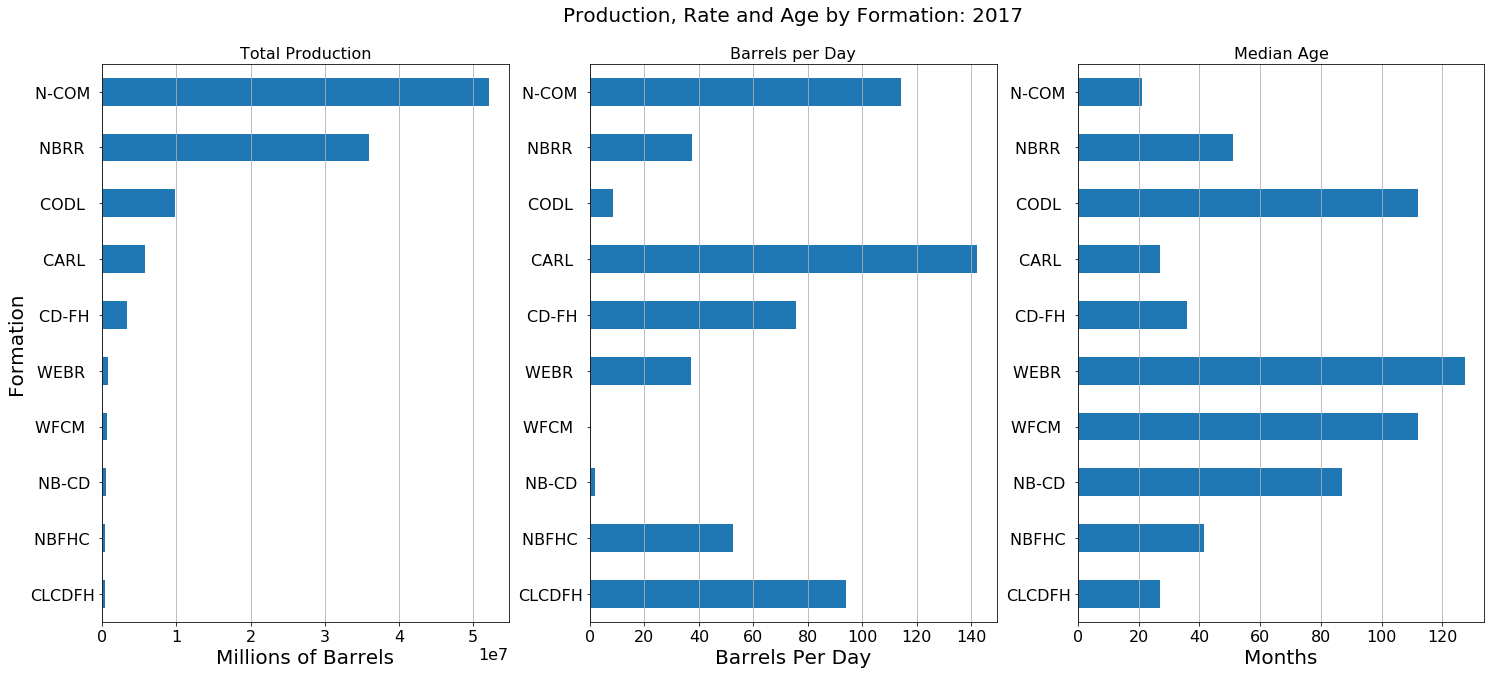

In [77]:
f = plt.figure(figsize=(24,10))
plt.suptitle('Production, Rate and Age by Formation: 2017',size=20)
ax = plt.subplot(1,3,1)
# df2.plot.barh(stacked=True);

prod_by_formation['oil_prod'].loc[top_n].plot.barh(ax=ax)
plt.title('Total Production',size=16)
plt.grid(axis='x')
plt.xlabel('Millions of Barrels')
plt.ylabel('Formation')

ax = plt.subplot(1,3,2)
prod_by_formation.loc[top_n].BblPerDay.plot.barh(ax=ax)
plt.title('Barrels per Day',size=16)
plt.grid(axis='x')
plt.xlabel('Barrels Per Day')
plt.ylabel('')

ax = plt.subplot(1,3,3)
prod_by_formation.loc[top_n].MedianAge.plot.barh(ax=ax)
plt.title('Median Age',size=16)
plt.grid(axis='x')
plt.xlabel('Months')
plt.ylabel('')
plt.subplots_adjust(left=0.1,  top=0.9)
#plt.tight_layout()


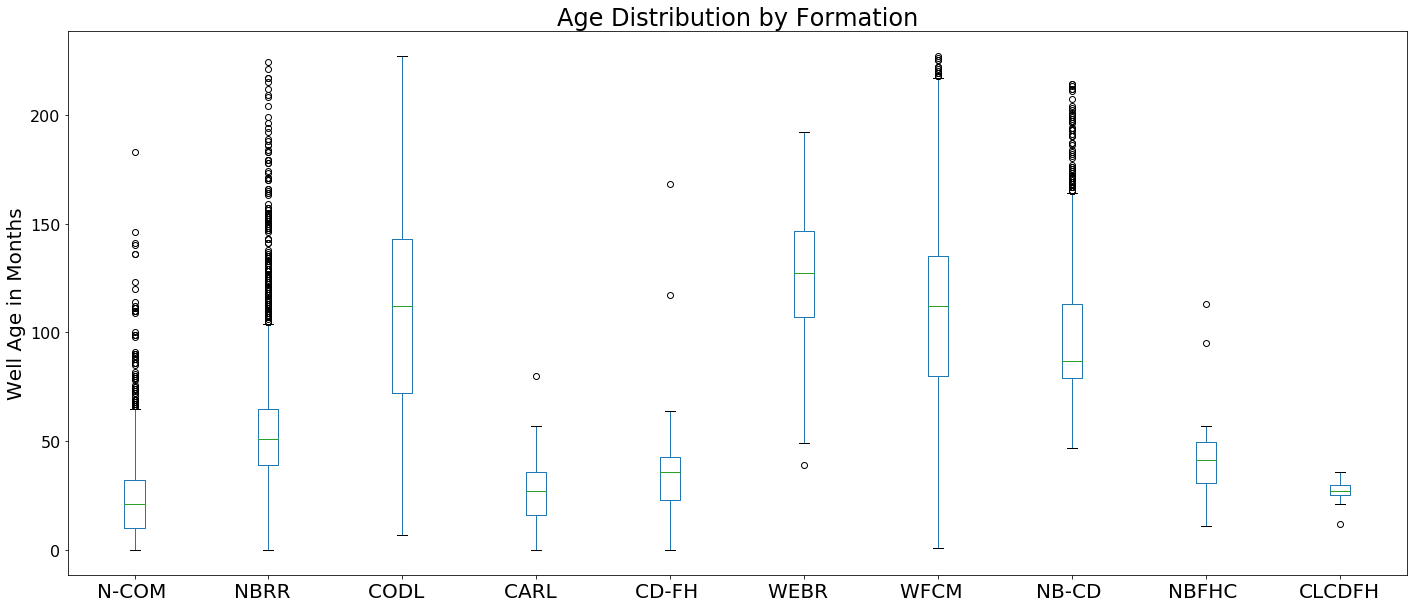

In [78]:
fig, ax = plt.subplots(figsize=(24,10))
for pos, form in enumerate(top_n[::-1]):
    oil_df.query('formation_code == @form')[['AgeAsOfReport']].boxplot(ax=ax,positions=[pos])
ax.set_xticks(range(pos+1))
ax.set_xticklabels(top_n[::-1],fontsize=20)
ax.set_xlim(xmin=-0.5)


plt.title('Age Distribution by Formation')
plt.ylabel('Well Age in Months')
plt.grid()
plt.show()

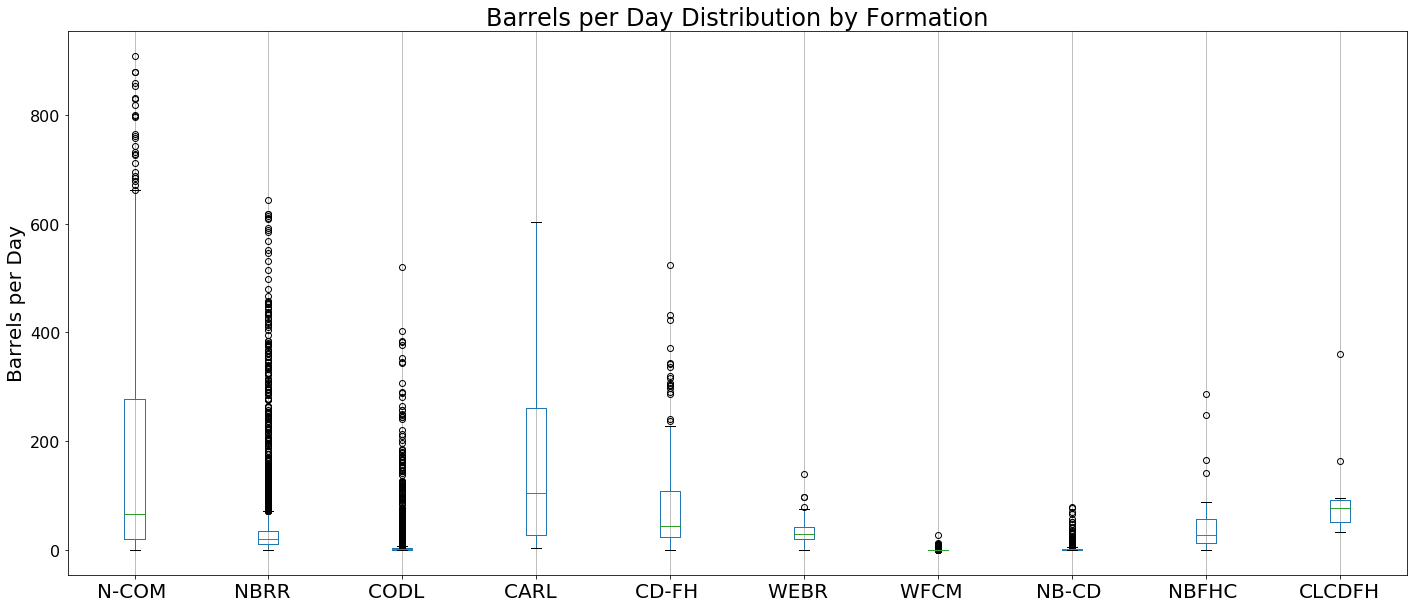

In [79]:
fig, ax = plt.subplots(figsize=(24,10))
for pos, form in enumerate(top_n[::-1]):
    oil_df.query('formation_code == @form')[['BblPerDay']].boxplot(ax=ax,positions=[pos])
ax.set_xticks(range(pos+1))
ax.set_xticklabels(top_n[::-1],fontsize=20)
ax.set_xlim(xmin=-0.5)

plt.title('Barrels per Day Distribution by Formation')
plt.ylabel('Barrels per Day')
plt.grid(axis='y')
plt.show()

## Longitudinal View

Here we look at the average barrels per day over the life of a well -- or at least that portion of a wells life for which we have data.

Data comes from COGGC downloads page: production data for the years 1999 through 2017.  Each reporting year is a separate zip file containing an Microsoft Access database.  We downloaded these files, used the SQL Server import tool to import the data into year-specific tables capturing production and well completion data.  We then created a view which concatenated (`union all`) the production data tables.  Finally we aggregated `group by API_num, Report_year` to get the production totals for each well for each year.

In the exercise below we'll look at all of the wells completed in 2008 and scatter plot their average output in  barrels per day through the year 2017.

In [80]:
Wells08 = prod_hist.query('CompleteDate >= \'1/1/2008\' & CompleteDate <= \'12/31/2008\'')

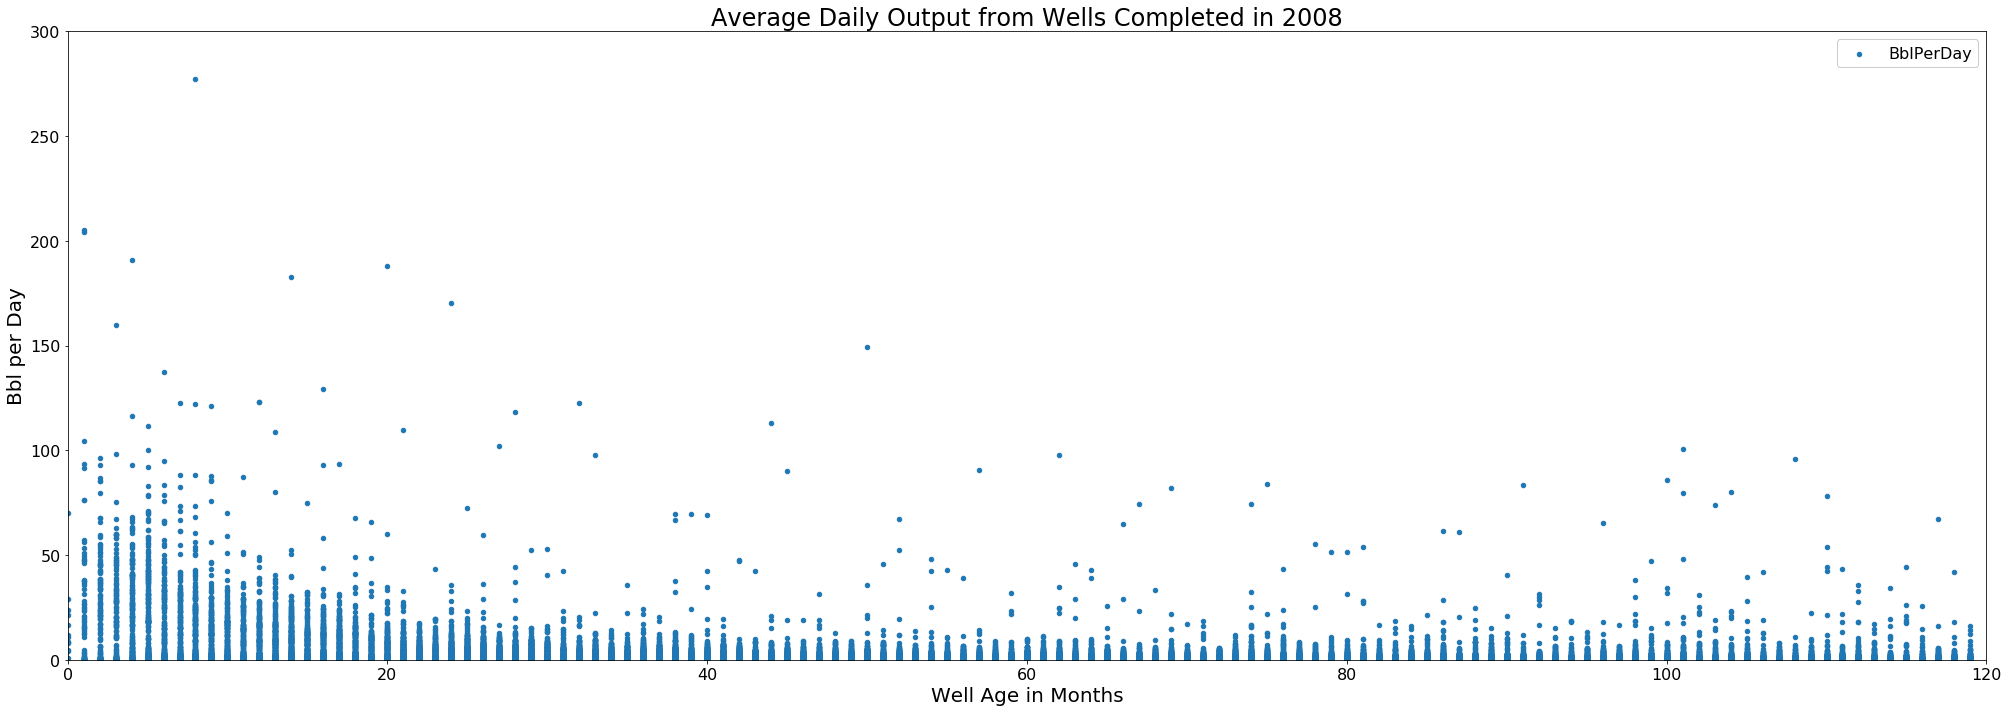

In [81]:

f = plt.figure(figsize=(28,10))
ax = plt.subplot()
ax.set_xlim(0,120)
ax.set_ylim(0,300)
plt.scatter(Wells08.AgeAsOfReport, Wells08.BblPerDay, s=20)
plt.title('Average Daily Output from Wells Completed in 2008')
plt.ylabel('Bbl per Day')
plt.xlabel('Well Age in Months')

plt.legend(numpoints=2,fontsize=16,markerscale=1, facecolor="white",framealpha=1)
plt.tight_layout()

## Questions for Future Research
+ **Stripper Wells:** Wells producing fewer than 15 barrels per day
    + Percent of output - how much output by year comes from stipper v. non-stripper wells?
    + Do wells turn off and turn back on in response to price changes
    + In general, do wells have on years and off years?
+ **Seasonality:** is there a seasonal pattern to well completions by month?
+ **No Output:** are there wells with completion dates but no output - are these dry holes?
    + What percentage of wells completed in 2016 had no output in 2017?
+ **Boom Years:**
    + If well output is highest in first 5 years why isn't oil production higher in the period immediately following the boom years in well completions (2004-2008)?
    + Is because operators chose not to produce from these wells (worldwide oil demand low, price low?) or because the wells that were completed during this time frame weren't as productive in their early years as the wells that are being completed now?
+ **Age Adjustment:**
    + Construct an age-adjusted measure of productivity by formation to account for some of the regions having newer wells than the others